In [1]:
import os
import sys

lib_path = os.path.abspath(".").replace("/Notebooks", "")
if lib_path not in sys.path: sys.path.append(lib_path)

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

FOLDER = "/Users/huuannguyen/Desktop/VIS-TKCT-2025/CT_Ngn3_1525"
COL = "CtyNgn3"

In [2]:
data_HOSE = pd.read_excel("/Users/huuannguyen/Desktop/VIS-TKCT-2025/HOSE_Field_2025_Audited.xlsx")
list_df = [pd.read_csv(f"{FOLDER}/{y}.csv") for y in range(2015, 2026)]
list_rank = [pd.read_csv(f"{FOLDER}/SUM_RANK_{y}.csv") for y in range(2015, 2026)]
years = [str(year) for year in range(2015, 2026)]
print([len(df) for df in list_df])
pdf = PdfPages(f'{FOLDER}/report.pdf')

[10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000]


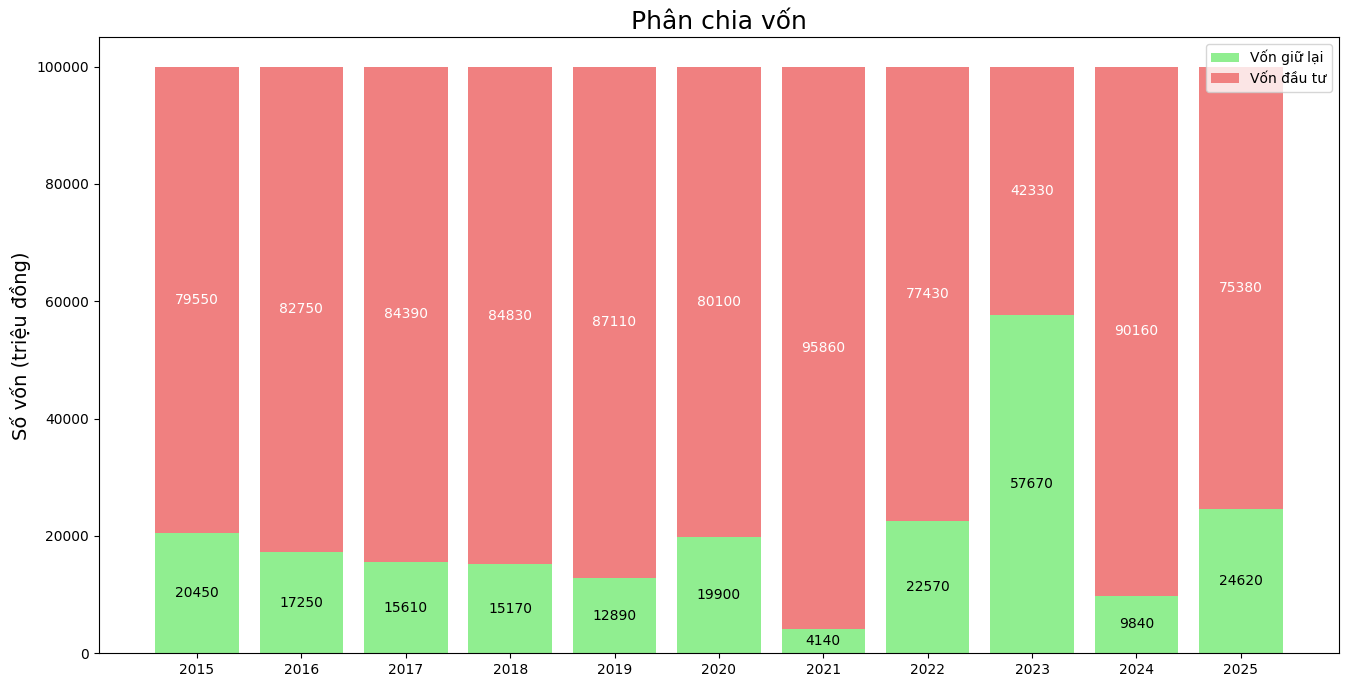

In [3]:
list_ratio = []
for df in list_df:
    ratio = df[df[COL].isna()].shape[0] / df.shape[0]
    list_ratio.append(ratio)
list_ratio = np.array(list_ratio)

# Giả sử mỗi năm tổng vốn là 100 tỷ
annual_capital = 100_000  # Đơn vị tỷ đồng

# Tính vốn giữ lại và đầu tư cho mỗi năm
retained_capital = np.round(list_ratio * annual_capital, 0).astype(int)
invested_capital = np.round((1 - list_ratio) * annual_capital, 0).astype(int)

# Vẽ biểu đồ cột chồng
plt.figure(figsize=(16, 8))
bar1 = plt.bar(years, retained_capital, color='lightgreen', label='Vốn giữ lại')
bar2 = plt.bar(years, invested_capital, bottom=retained_capital, color='lightcoral', label='Vốn đầu tư')

# In số liệu đã làm tròn trên từng phần
for i in range(len(years)):
    plt.text(i, retained_capital[i] / 2, f'{retained_capital[i]}', ha='center', va='center', fontsize=10, color='black')
    plt.text(i, retained_capital[i] + invested_capital[i] / 2, f'{invested_capital[i]}', ha='center', va='center', fontsize=10, color='white')

# Thêm tiêu đề và nhãn
plt.title('Phân chia vốn', fontsize=18)
plt.ylabel('Số vốn (triệu đồng)', fontsize=14)
plt.legend()

# plt.savefig(f"{FOLDER}/fig1.png")
pdf.savefig()
plt.show()

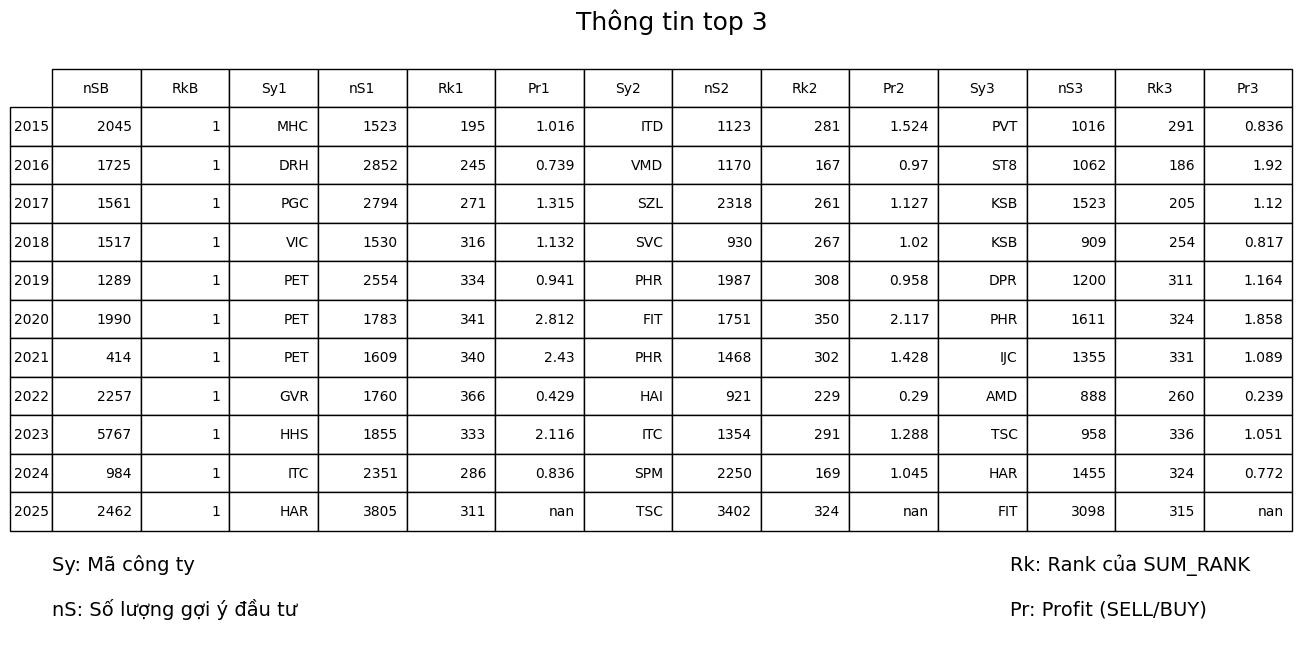

In [4]:
def get_info(index, data_HOSE: pd.DataFrame, counter, rank: pd.DataFrame, year):
    nS1 = counter[index][1]
    Sy1 = counter[index][0]
    Pr1 = data_HOSE[(data_HOSE["TIME"] == year) & (data_HOSE["SYMBOL"] == Sy1)]
    assert Pr1.shape[0] == 1
    Pr1 = Pr1.iloc[0]["PROFIT"]

    RK1 = rank[rank["TIME"] == year].copy()
    RK1.sort_values("SUM_RANK", ignore_index=True, inplace=True)
    RK1 = RK1[RK1["SYMBOL"] == Sy1]
    assert RK1.shape[0] == 1
    RK1 = RK1.index[0] + 1

    return Sy1, nS1, RK1, Pr1


list_info = []
for y in range(2015, 2026):
    df = list_df[y-2015]
    rank = list_rank[y-2015]

    temp = df[df[COL].notna()]
    syms = "_".join(temp[COL]).split("_")
    counter = Counter(syms)
    counter = sorted(counter.items(), key=lambda x:x[1], reverse=True)[:3]
    nSB = df[df[COL].isna()].shape[0]

    info = {"nSB": nSB}
    RKB = rank[rank["TIME"] == y].copy()
    RKB.sort_values("SUM_RANK", ignore_index=True, inplace=True, ascending=False)
    RKB = RKB[RKB["SYMBOL"] == "NOT_INVEST"]
    assert RKB.shape[0] == 1
    RKB = RKB.index[0] + 1
    info.update({"RkB": RKB})

    for index in range(3):
        Sy, nS, RK, Pr = get_info(index, data_HOSE, counter, rank, y)
        info.update({
            f"Sy{index+1}": Sy,
            f"nS{index+1}": nS,
            f"Rk{index+1}": RK,
            f"Pr{index+1}": np.round(Pr, 3)
        })
    list_info.append(info)

df_temp = pd.DataFrame(list_info, index=range(2015, 2026))

plt.figure(figsize=(16, 8))
plt.axis('tight')
plt.axis('off')
plt.table(cellText=df_temp, loc="center", bbox=[0, 0.2, 1, 0.75])
plt.title("Thông tin top 3", fontsize=18)
plt.text(-0.055, -0.04, "Sy: Mã công ty", fontsize=14, ha="left")
plt.text(-0.055, -0.048, "nS: Số lượng gợi ý đầu tư", fontsize=14)
plt.text(0.03, -0.04, "Rk: Rank của SUM_RANK", fontsize=14, ha="left")
plt.text(0.03, -0.048, "Pr: Profit (SELL/BUY)", fontsize=14, ha="left")

# plt.savefig(f"{FOLDER}/fig2.png")
pdf.savefig()
plt.show()

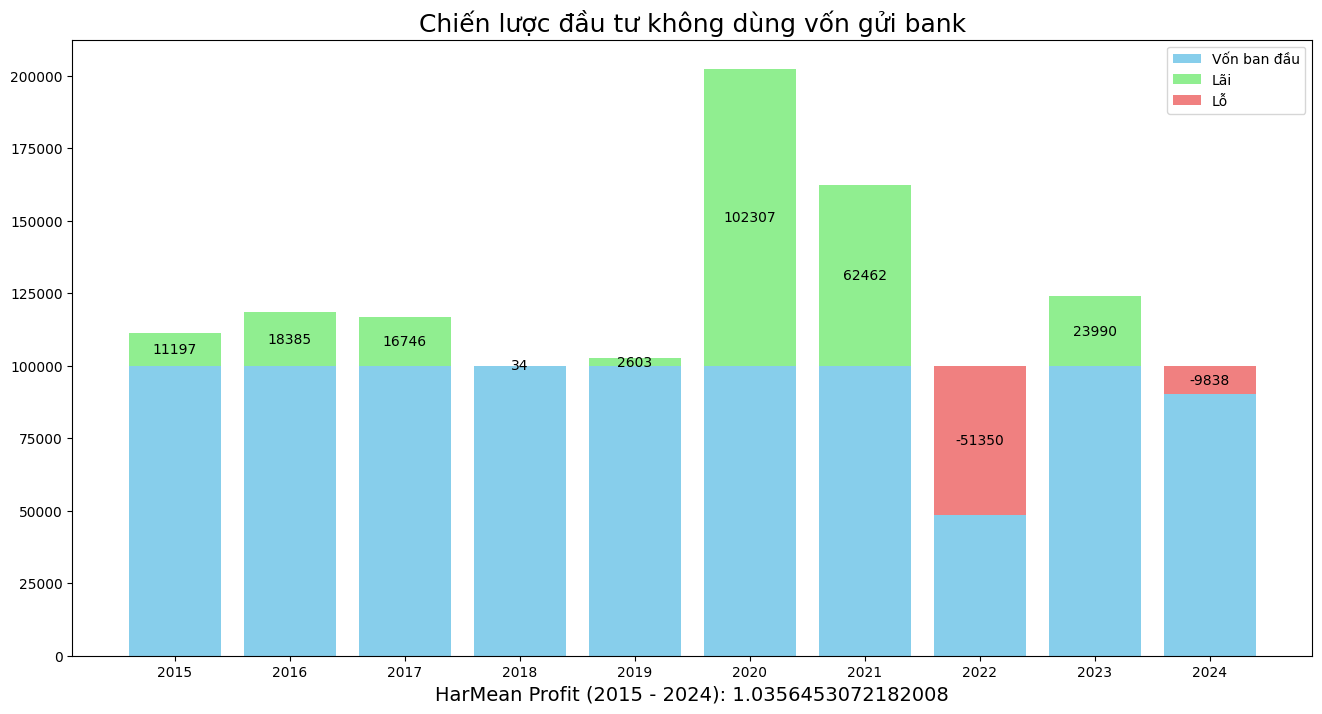

In [5]:
df_temp["Overall"] = (df_temp["Pr1"] + df_temp["Pr2"] + df_temp["Pr3"]) / 3.0
list_money_after = []
for i in range(len(list_df)-1):
    retain = retained_capital[i]
    invest = invested_capital[i]
    profit = df_temp.loc[i+2015, "Overall"]
    list_money_after.append(retain * 1.06 + invest * profit)
list_money_after = np.array(list_money_after) - annual_capital

plt.figure(figsize=(16, 8))

# Vẽ phần vốn ban đầu
plt.bar(years[:-1], [annual_capital]*len(years[:-1]), color='skyblue', label='Vốn ban đầu')

# Phân tách chênh lệch thành lãi và lỗ
profit = np.where(list_money_after > 0, list_money_after, 0)
loss = np.where(list_money_after < 0, list_money_after, 0)

# Vẽ phần lãi
plt.bar(years[:-1], profit, bottom=annual_capital, color='lightgreen', label='Lãi')

# Vẽ phần lỗ
plt.bar(years[:-1], loss, bottom=annual_capital, color='lightcoral', label='Lỗ')

# In số liệu trên từng phần
for i in range(len(years)-1):
    if profit[i] > 0:
        plt.text(i, annual_capital + profit[i] / 2, f'{profit[i]:.0f}', ha='center', va='center', fontsize=10, color='black')
    if loss[i] < 0:
        plt.text(i, annual_capital + loss[i] / 2, f'{loss[i]:.0f}', ha='center', va='center', fontsize=10, color='black')

harmean = len(list_money_after) / sum(1.0/((list_money_after+annual_capital)/annual_capital))
plt.xlabel(f"HarMean Profit (2015 - 2024): {harmean}", fontsize=14)
plt.title("Chiến lược đầu tư không dùng vốn gửi bank", fontsize=18)
plt.legend()

# plt.savefig(f"{FOLDER}/fig3.png")
pdf.savefig()
plt.show()

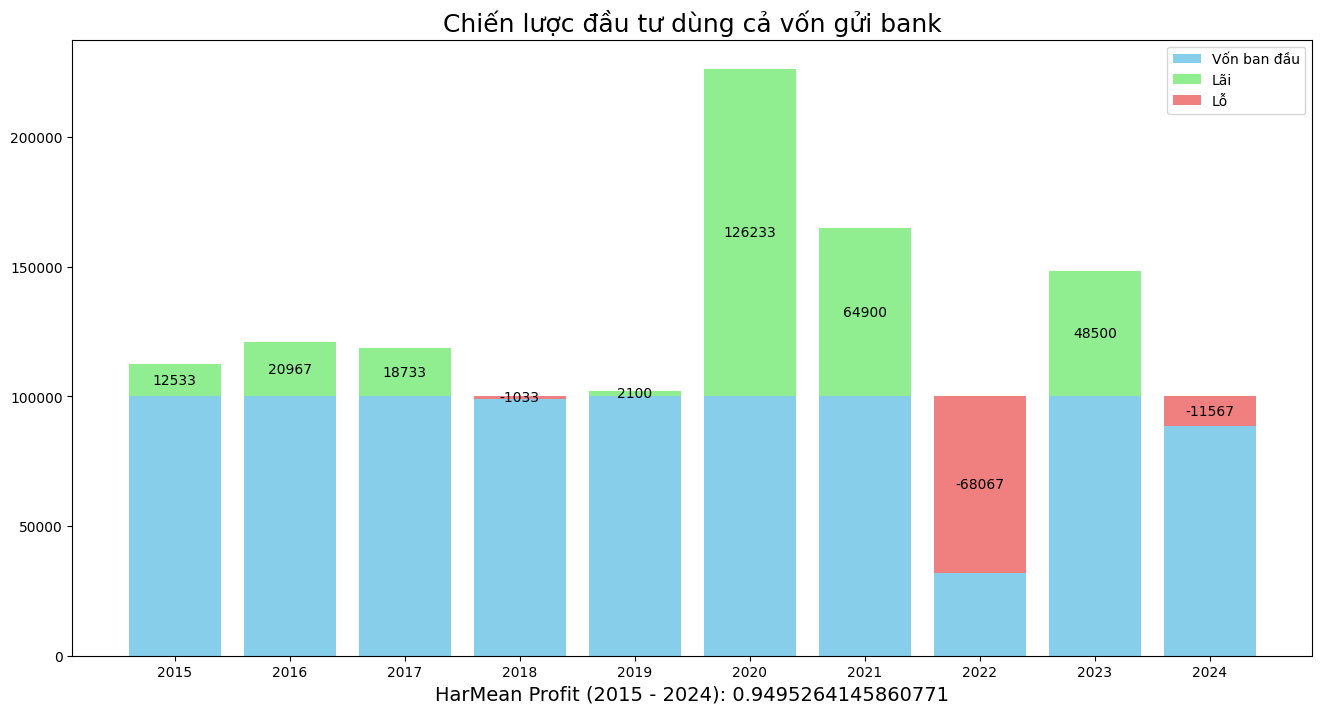

In [6]:
df_temp["Overall"] = (df_temp["Pr1"] + df_temp["Pr2"] + df_temp["Pr3"]) / 3.0
list_money_after = []
for i in range(len(list_df)-1):
    retain = retained_capital[i]
    invest = invested_capital[i]
    profit = df_temp.loc[i+2015, "Overall"]
    list_money_after.append(retain * profit + invest * profit)
list_money_after = np.array(list_money_after) - annual_capital

plt.figure(figsize=(16, 8))

# Vẽ phần vốn ban đầu
plt.bar(years[:-1], [annual_capital]*len(years[:-1]), color='skyblue', label='Vốn ban đầu')

# Phân tách chênh lệch thành lãi và lỗ
profit = np.where(list_money_after > 0, list_money_after, 0)
loss = np.where(list_money_after < 0, list_money_after, 0)

# Vẽ phần lãi
plt.bar(years[:-1], profit, bottom=annual_capital, color='lightgreen', label='Lãi')

# Vẽ phần lỗ
plt.bar(years[:-1], loss, bottom=annual_capital, color='lightcoral', label='Lỗ')

# In số liệu trên từng phần
for i in range(len(years)-1):
    if profit[i] > 0:
        plt.text(i, annual_capital + profit[i] / 2, f'{profit[i]:.0f}', ha='center', va='center', fontsize=10, color='black')
    if loss[i] < 0:
        plt.text(i, annual_capital + loss[i] / 2, f'{loss[i]:.0f}', ha='center', va='center', fontsize=10, color='black')

harmean = len(list_money_after) / sum(1.0/((list_money_after+annual_capital)/annual_capital))
plt.xlabel(f"HarMean Profit (2015 - 2024): {harmean}", fontsize=14)
plt.title("Chiến lược đầu tư dùng cả vốn gửi bank", fontsize=18)
plt.legend()

# plt.savefig(f"{FOLDER}/fig4.png")
pdf.savefig()
plt.show()

In [7]:
pdf.close()